Visual RAG model

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
from PIL import Image
import pickle
import matplotlib.pyplot as plt

# Initialize CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def encode_image(image_path):
    """Encodes an image into a CLIP embedding."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features / image_features.norm(p=2, dim=-1, keepdim=True)

def build_database(image_paths, descriptions, labels, database_path):
    """Builds a database of image embeddings, descriptions, labels, and image paths and saves it."""
    database = []
    for image_path, description, label in zip(image_paths, descriptions, labels):
        embedding = encode_image(image_path)
        database.append({"embedding": embedding.cpu().numpy(), "description": description, "label": label, "image_path": image_path})
    with open(database_path, 'wb') as f:
        pickle.dump(database, f)
    return database

def load_database(database_path):
    """Loads the database of image embeddings, descriptions, labels, and image paths."""
    with open(database_path, 'rb') as f:
        return pickle.load(f)

def find_closest_match(query_image_path, database):
    """Finds the closest matching description for a query image."""
    query_embedding = encode_image(query_image_path).cpu().numpy()
    similarities = [
        cosine_similarity(query_embedding, entry["embedding"])
        for entry in database
    ]
    best_match_idx = np.argmax(similarities)
    return database[best_match_idx]["description"], similarities[best_match_idx][0][0]

def find_image_by_description_or_label(query, database):
    """Finds the image path corresponding to a given description or label."""
    for entry in database:
        if query.lower() == entry["description"].lower() or query.lower() == entry["label"].lower():
            return entry["image_path"]
    return None

def calculate_cosine_similarity(database, query_image_path):
    """Calculates cosine similarity between a query image and images in the database."""
    query_embedding = encode_image(query_image_path)
    similarities = []
    for entry in database:
        similarity = cosine_similarity(query_embedding, entry["embedding"])
        similarities.append(similarity[0][0])
    return similarities

def find_best_match(database, query_image_path, labels):
    """Finds the best-matched label for a query image."""
    similarities = calculate_cosine_similarity(database, query_image_path)
    best_match_idx = np.argmax(similarities)
    return labels[best_match_idx], similarities[best_match_idx]

# Example setup
image_paths = [
    "/content/GreatWallOfChina.jpg",
    "/content/GreatWallOfChina.jpg",
    "/content/TajMahal.jpg",
    "/content/StatueofLiberty.jpg",
    "/content/MachuPicchu.jpg",
    "/content/Colosseum.jpg",
    "/content/SydneyOperaHouse.jpg",
    "/content/PyramidsofGiza.jpg",
    "/content/Santorini.jpg",
    "/content/NiagaraFalls.jpg",
    "/content/MountFuji.jpg",
    "/content/PalaceofVersailles.jpg",
    "/content/Stonehenge.jpg",
    "/content/AngkorWat.jpg",
    "/content/TheGrandCanyon.jpg"
]

descriptions = [
    "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It was constructed between 1887 and 1889 and has since become a global cultural icon of France. Standing 324 meters tall, the Eiffel Tower offers breathtaking views of the Paris skyline.",
    "The Great Wall of China is a series of fortifications made of various materials that stretch over 13,000 miles across northern China. It was built to protect the Chinese states from invasions and raids. The wall is one of the most impressive and iconic architectural feats in history.",
    "The Taj Mahal is an ivory-white marble mausoleum built by the Mughal emperor Shah Jahan in memory of his wife Mumtaz Mahal. Completed in 1653, it is a symbol of love and one of the Seven Wonders of the World. The stunning symmetry and intricate carvings make it a masterpiece of Mughal architecture.",
    "The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor. A gift from France to the United States in 1886, it represents freedom, democracy, and the enduring relationship between the two nations. The statue is an iconic symbol of hope and liberty.",
    "Machu Picchu is a 15th-century Inca citadel set high in the Andes Mountains in Peru. It was built by the Inca emperor Pachacuti and abandoned in the 16th century. The site is famous for its dry-stone construction, terraces, and stunning panoramic views of the surrounding mountains and valleys.",
    "The Colosseum is an ancient amphitheater located in the center of Rome. Built between 70-80 AD, it could hold up to 80,000 spectators and was used for gladiatorial contests, public spectacles, and theatrical performances. It remains an enduring symbol of the grandeur of ancient Roman engineering.",
    "The Sydney Opera House is a multi-venue performing arts center situated on Bennelong Point in Sydney Harbour. It is recognized for its innovative design and distinctive shell-like roof. As one of the most famous and photographed buildings in the world, it hosts over 1,500 performances annually.",
    "The Pyramids of Giza are three massive stone structures built as tombs for ancient Egyptian pharaohs. The largest pyramid, the Great Pyramid, was constructed for Pharaoh Khufu. These ancient wonders are the last surviving of the Seven Wonders of the Ancient World.",
    "Santorini is a volcanic island in the Aegean Sea, famous for its white-washed buildings, blue-domed churches, and stunning sunsets. It is part of the Cyclades islands and is known for its crystal-clear waters, unique black sand beaches, and rich history tied to ancient volcanic eruptions.",
    "Niagara Falls is a group of three waterfalls straddling the border between Canada and the United States. Known for its breathtaking beauty and powerful flow of water, it attracts millions of visitors every year. The falls are a natural wonder and provide opportunities for boat rides and scenic viewpoints.",
    "Mount Fuji is Japan's tallest mountain, standing at 3,776 meters. It is an active stratovolcano and a revered cultural symbol. Surrounded by beautiful lakes and forests, it offers an iconic view and a popular hiking destination, especially during the climbing season in summer.",
    "The Palace of Versailles is a former royal residence located just outside Paris. It was the principal royal residence of the French kings from Louis XIV to Louis XVI. Known for its opulent architecture, the palace includes stunning gardens, fountains, and the Hall of Mirrors.",
    "Stonehenge is a prehistoric monument consisting of a ring of standing stones, each around 13 feet high. Located in Wiltshire, England, it is believed to have been constructed around 3000 BC. The purpose of the site remains a mystery, with theories ranging from astronomical observatory to religious rituals.",
    "Angkor Wat is a temple complex in Cambodia, originally constructed in the early 12th century by King Suryavarman II. It is the largest religious monument in the world, with intricate carvings depicting Hindu mythology and Buddhist teachings. Angkor Wat is a UNESCO World Heritage Site.",
    "The Grand Canyon is a colossal canyon carved by the Colorado River in the state of Arizona. Its immense size and colorful geological formations make it a popular destination for hikers, photographers, and nature enthusiasts. The canyon stretches over 277 miles and is a UNESCO World Heritage Site."
]

labels = [
    "Eiffel Tower", "The Great Wall of China", "Taj Mahal", "Statue of Liberty",
    "Machu Picchu", "The Colosseum", "Sydney Opera House", "Pyramids of Giza",
    "Santorini", "Niagara Falls", "Mount Fuji", "The Palace of Versailles",
    "Stonehenge", "Angkor Wat", "The Grand Canyon"
]

database_path = "/content/image_database.pkl"  # Path to save the database

# Build and save the database
database = build_database(image_paths, descriptions, labels, database_path)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Given path of the image to generate the description

In [2]:
# Load the database
database = load_database(database_path)

# Query with a new image
query_image_path = "/content/MachuPicchu.jpg"  # Replace with the path to your query image
result_description, similarity_score = find_closest_match(query_image_path, database)
print("Generated Description:", result_description)
print("Similarity Score:", similarity_score)

Generated Description: Machu Picchu is a 15th-century Inca citadel set high in the Andes Mountains in Peru. It was built by the Inca emperor Pachacuti and abandoned in the 16th century. The site is famous for its dry-stone construction, terraces, and stunning panoramic views of the surrounding mountains and valleys.
Similarity Score: 0.9999999


Given description to generate image

Image Path: /content/TajMahal.jpg


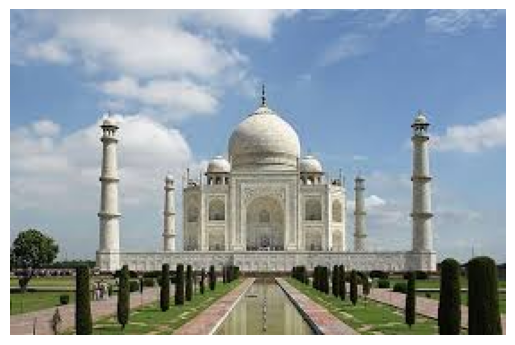

In [3]:

# Query by description or label
description_or_label_query = "Taj Mahal"  # Replace with your description or label
result_image_path = find_image_by_description_or_label(description_or_label_query, database)
if result_image_path:
    print("Image Path:", result_image_path)
    result_image = Image.open(result_image_path)
    plt.imshow(result_image)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image
else:
    print("No image found for the given description or label.")

Using Cosine Similarity to evaluate the performance of the model

In [4]:
def find_best_match(database, query_image_path, labels):
    """Finds the best-matched label for a query image and returns all similarity scores."""
    query_embedding = encode_image(query_image_path)
    similarities = []
    for entry in database:
        similarity = cosine_similarity(query_embedding, entry["embedding"])
        similarities.append(similarity[0][0])

    # Find the best match
    best_match_idx = np.argmax(similarities)
    best_match_label = labels[best_match_idx]
    best_similarity = similarities[best_match_idx]

    # Print all similarity scores
    for idx, similarity in enumerate(similarities):
        print(f"Similarity with {labels[idx]}: {similarity:.4f}")

    return best_match_label, best_similarity


# Query with an example image
query_image_path = "/content/NiagaraFalls.jpg"  # Replace with the path to your query image
best_match_label, best_similarity = find_best_match(database, query_image_path, labels)

# Print the best match and similarity score
print()
print("Best Matched Label:", best_match_label)
print("Best Similarity:", f"{best_similarity:.4f}")


Similarity with Eiffel Tower: 0.6732
Similarity with The Great Wall of China: 0.6732
Similarity with Taj Mahal: 0.6669
Similarity with Statue of Liberty: 0.7113
Similarity with Machu Picchu: 0.6566
Similarity with The Colosseum: 0.6499
Similarity with Sydney Opera House: 0.7169
Similarity with Pyramids of Giza: 0.6979
Similarity with Santorini: 0.6558
Similarity with Niagara Falls: 1.0000
Similarity with Mount Fuji: 0.6895
Similarity with The Palace of Versailles: 0.6000
Similarity with Stonehenge: 0.6819
Similarity with Angkor Wat: 0.6247
Similarity with The Grand Canyon: 0.6726

Best Matched Label: Niagara Falls
Best Similarity: 1.0000
